In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15})
from gradientDescent import ztheta
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GM
from sklearn.metrics import adjusted_rand_score as ARS
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew, kurtosis
from scipy.stats import gaussian_kde
from scipy.spatial.distance import braycurtis as bcd

Load dataset of interest

In [3]:
cow_data = np.array(pd.read_csv('data_files/data_CHKN.csv', index_col=0))

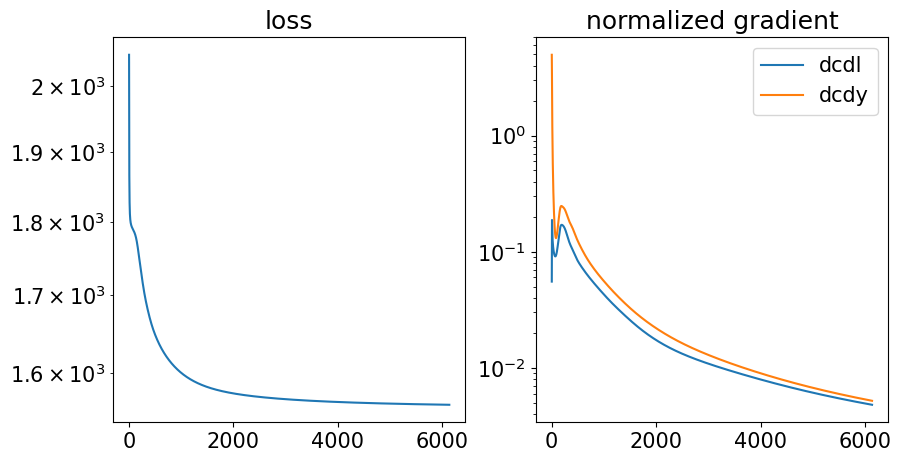

In [5]:
cow_obj = ztheta(cow_data, 0.01, 70000, 16, True)

cow_z = cow_obj.z
cow_theta = cow_obj.theta

In [61]:
# df = pd.DataFrame(cow_obj.theta)
# df.to_csv('fig_2_files/cow_theta.csv')

# cow_z = np.array(pd.read_csv("fig_2_files/cow_z.csv", index_col=0))
# cow_theta = np.array(pd.read_csv("fig_2_files/cow_theta.csv", index_col=0))

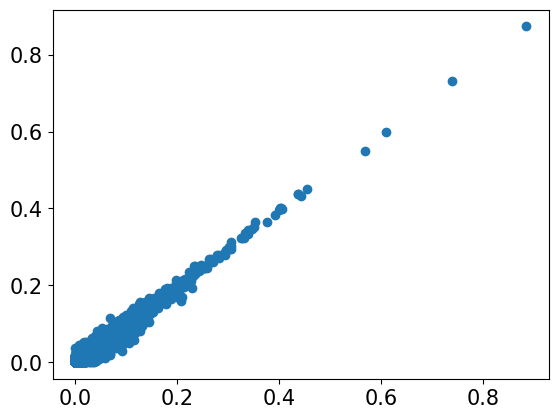

In [6]:
reconstruction = np.exp(-np.matmul(cow_z, cow_theta))
recon_sum = np.sum(reconstruction, axis=1)
reconstruction = reconstruction/recon_sum[:, np.newaxis]

plt.scatter(cow_data, reconstruction)
plt.show()

Number of clusters in latents = 2


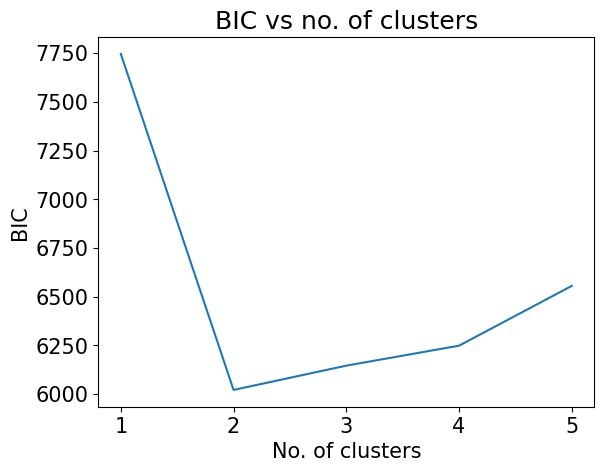

In [7]:
bic_list = []
for i in range(1, 6):
    best_score = -np.inf
    best_model = None
    for _ in range(50):
        gm = GM(n_components=i).fit(cow_z)
        current_score = gm.score(cow_z)
        if current_score > best_score:
            best_score = current_score
            best_model = gm
    bic_list.append(best_model.bic(cow_z))

num_clusters = np.argsort(bic_list)[0] + 1

print('Number of clusters in latents = {}'.format(num_clusters))
plt.plot(np.arange(1,6), bic_list)
plt.xticks(np.arange(1,6))
plt.title('BIC vs no. of clusters')
plt.xlabel('No. of clusters')
plt.ylabel('BIC')
plt.show()

In [8]:
best_score = -np.inf
for i in range(100):
    model = GM(n_components=num_clusters).fit(cow_z)
    score = np.mean(model.score_samples(cow_z))
    if score > best_score:
        best_score = np.copy(score)
        gm = model

z_samples, sample_labels = gm.sample(cow_data.shape[0])

sample_construction = np.exp(-np.matmul(z_samples, cow_theta))
recon_sum = np.sum(sample_construction, axis=1)
sample_construction = sample_construction/recon_sum[:, np.newaxis]

print(np.mean(gm.score_samples(cow_z)), best_score)

-4.912745327936116 -4.912745327936116


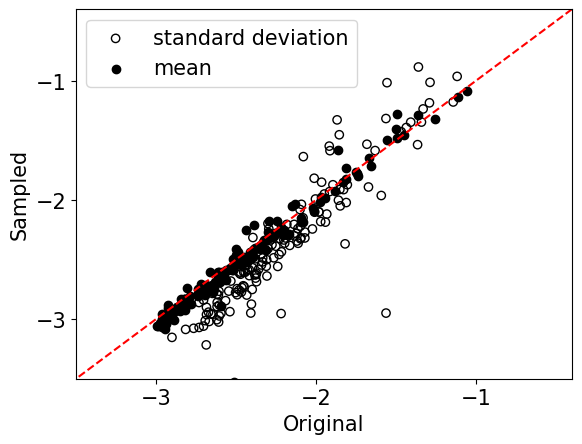

In [9]:
x = np.linspace(-4, 0, 100)

data_1_mean = np.log10(np.mean(cow_data, axis=0))
data_2_mean = np.log10(np.mean(sample_construction, axis=0))
data_1_std = np.log10(np.std(cow_data, axis=0))
data_2_std = np.log10(np.std(sample_construction, axis=0))

plt.scatter(data_1_std, data_2_std, facecolor='none', color='black', label='standard deviation')
plt.scatter(data_1_mean, data_2_mean, color='black', label='mean')
plt.plot(x, x, '--', color='red')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(4e-4, 5e-1)
# plt.ylim(4e-4, 5e-1)
plt.xlim(-3.5, -0.4)
plt.ylim(-3.5, -0.4)
plt.xlabel('Original')
plt.ylabel('Sampled')
plt.xticks([-3, -2, -1])
plt.yticks([-3, -2, -1])
plt.legend()
plt.savefig('figures/fig_2_a.pdf', dpi=300, format='pdf')
plt.show()

/tmp/tmp.1bAp8Nfksx/ipykernel_3029195/1764246211.py:3: RuntimeWarning: invalid value encountered in log10
  data_1_cov = np.log10(np.cov(cow_data, rowvar=False))
/tmp/tmp.1bAp8Nfksx/ipykernel_3029195/1764246211.py:4: RuntimeWarning: invalid value encountered in log10
  data_2_cov = np.log10(np.cov(sample_construction, rowvar=False))


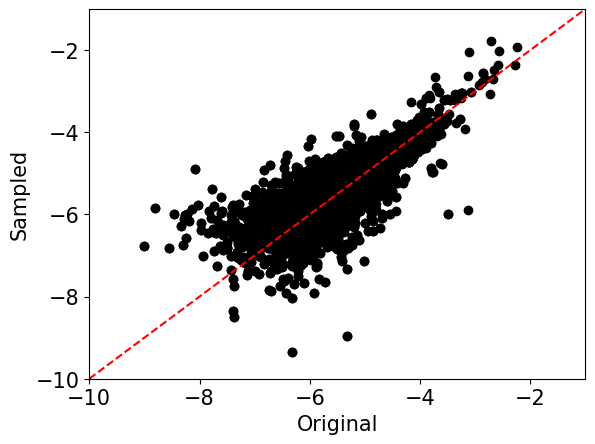

In [10]:
x = np.linspace(-10, -1, 100)

data_1_cov = np.log10(np.cov(cow_data, rowvar=False))
data_2_cov = np.log10(np.cov(sample_construction, rowvar=False))

plt.scatter(data_1_cov, data_2_cov, color='black')
plt.plot(x, x, '--', color='red')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(-10, -1)
plt.ylim(-10, -1)
plt.xticks([-10, -8, -6, -4, -2])
plt.yticks([-10, -8, -6, -4, -2])
plt.xlabel('Original')
plt.ylabel('Sampled')
plt.savefig('figures/fig_2_b.pdf', dpi=300, format='pdf')
plt.show()

In [ ]:
z_samples, sample_labels = gm.sample(cow_data.shape[0])

sample_construction = np.exp(-np.matmul(z_samples, cow_theta))
recon_sum = np.sum(sample_construction, axis=1)
sample_construction = sample_construction/recon_sum[:, np.newaxis]

In [11]:
def select_equally_spaced_indices(sorted_array, num_elements):
    """
    Selects indices from a sorted array that are equally spaced in magnitude.

    Parameters:
        sorted_array (list): A sorted array.
        num_elements (int): Number of elements to select.

    Returns:
        list: List of selected indices.
    """
    array_length = len(sorted_array)
    
    # Calculate the step size
    step_size = (sorted_array[-1] - sorted_array[0]) / (num_elements - 1)
    
    # Initialize list to store selected elements
    selected_indices = []
    
    # Iterate through the array and select elements at regular intervals
    current_element = sorted_array[0]
    for _ in range(num_elements):
        # Find the closest element in the array to the current value
        closest_element = min(sorted_array, key=lambda x: abs(x - current_element))
        selected_indices.append(np.where(sorted_array == closest_element)[0][0])
        current_element += step_size
    
    return selected_indices

def make_inv_cummulative_abundance_plot(data, label, color):
    x_data = np.sort(np.log10(data[np.nonzero(data)]), axis=None)
    inv_cum = np.cumsum(x_data)
    inv_cum = inv_cum[-1] - inv_cum
    inv_cum = inv_cum / inv_cum[0]
    inv_cum = np.log10(inv_cum)
    idx = select_equally_spaced_indices(x_data, 70)
    plt.scatter(x_data[idx], inv_cum[idx], label=label, color=color)
    plt.title('Inverse cumulative abundance distribution')
    # plt.yscale('log')
    # plt.xlim(1e-4,1)
    plt.ylim(-4,0.2)
    plt.xlim(-4, -0.5)
    plt.xticks([-4,-3,-2,-1])


    low = min(x_data, key=lambda x: abs(x - (-2.8)))
    high = min(x_data, key=lambda x: abs(x - (-1)))
    low_idx = np.where(x_data == low)[0][0]
    high_idx = np.where(x_data == high)[0][0]

    z = np.polyfit(x_data[low_idx:high_idx], inv_cum[low_idx:high_idx], 1)
    print(z)
    p = np.poly1d(z)
    x = np.linspace(-3, -0.5, 100)
    y = p(x)
    plt.plot(x,y,'--' ,color=color)

/tmp/tmp.1bAp8Nfksx/ipykernel_3029195/1117807087.py:6: RuntimeWarning: divide by zero encountered in log10
  inv_cum = np.log10(inv_cum)


[-1.03277196 -3.00160577]
[-1.11856488 -3.47481577]


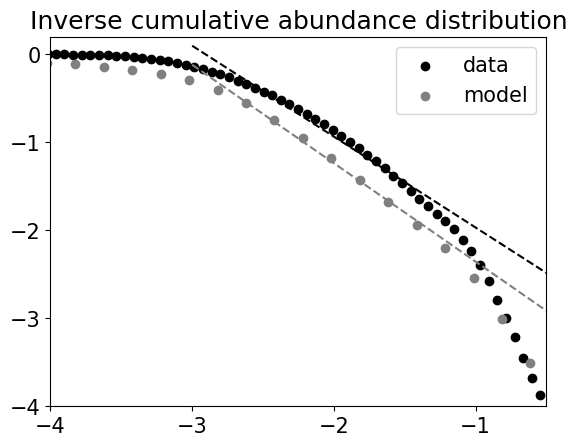

In [14]:
make_inv_cummulative_abundance_plot(cow_data, 'data', 'black')
make_inv_cummulative_abundance_plot(sample_construction, 'model', 'grey')
plt.legend()
plt.savefig('figures/fig_2_c.pdf', dpi=300, format='pdf')
plt.show()

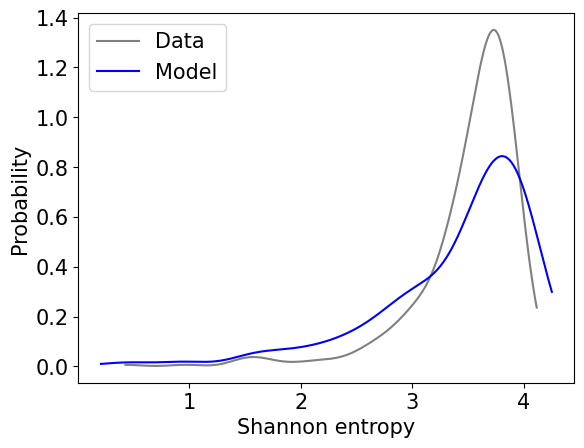

In [17]:
cow_shannon = sp.stats.entropy(cow_data, axis=1)
cow_kde = gaussian_kde(cow_shannon)
cow_x = np.linspace(min(cow_shannon), max(cow_shannon), 1000)
cow_kde_values = cow_kde(cow_x)

sample_shannon = sp.stats.entropy(sample_construction, axis=1)
sample_kde = gaussian_kde(sample_shannon)
sample_x = np.linspace(min(sample_shannon), max(sample_shannon), 1000)
sample_kde_values = sample_kde(sample_x)


plt.plot(cow_x, cow_kde_values, label='Data', color='grey')
plt.plot(sample_x, sample_kde_values, label='Model', color='blue')
plt.legend()
plt.xlabel('Shannon entropy')
plt.ylabel('Probability')
plt.savefig('figures/fig_2_d.pdf', dpi=300, format='pdf')
plt.show()

In [18]:
def closest_and_random_BCD(data, label, color):
    bcd_all = []
    bcd_close = []
    idx_set = set()
    for i in range(data.shape[0]):
        if i in idx_set:  # Skip iteration if i already exists in idx_set # Might need to be deleted and instead change bcd_close.append to be conditioned on i not in set
            continue
        
        bcd_low = np.inf
        idx = None
        for j in range(i+1, data.shape[0]):
            bcd_temp = float(bcd(data[i], data[j]))
            bcd_all.append(bcd_temp)
            if bcd_temp < bcd_low and j not in idx_set:
                bcd_low = bcd_temp
                idx = j
        bcd_close.append(bcd_low)
        idx_set.add(idx)
        idx_set.add(i)

    bcd_all = np.array(bcd_all)
    bcd_close = np.array(bcd_close)

    bcd_close = bcd_close[~np.isnan(bcd_close) & ~np.isinf(bcd_close)]

    rand_idx = np.random.choice(bcd_all.shape[0], bcd_close.shape[0], replace=False)


    close_kde = gaussian_kde(bcd_close)
    close_x = np.linspace(min(bcd_close), max(bcd_close), 1000)
    close_kde_values = close_kde(close_x)

    all_kde = gaussian_kde(bcd_all)
    all_x = np.linspace(min(bcd_all), max(bcd_all), 1000)
    all_kde_values = all_kde(all_x)


    plt.plot(close_x, close_kde_values, label='closest '+label, color=color)
    plt.plot(all_x, all_kde_values, label='all pairs '+label, color=color)


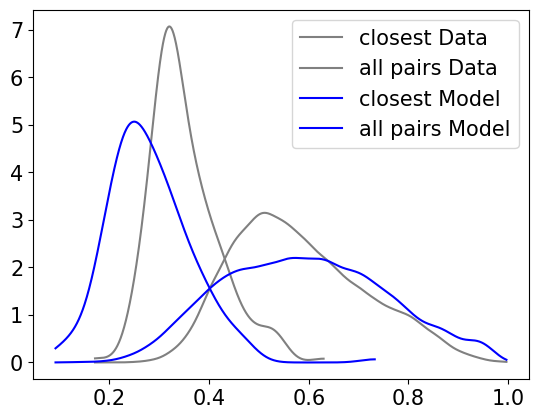

In [20]:
closest_and_random_BCD(cow_data, 'Data', 'grey')
closest_and_random_BCD(sample_construction, 'Model', 'blue')
plt.legend()
# plt.savefig('figures/fig_2_e.pdf', dpi=300, format='pdf')
plt.show()

## Embedding testing

1. Split the main dataset into train and test dataset
2. Learn latent representation and feature matrix from the train dataset
3. Use train dataset's feature matrix to embed test dataset
4. Load a validation dataset (microbiomes in similar environments if available)
5. Embed validation dataset using train datset's feature matrix
6. Embed validation dataset using a scrambled version of the training dataset's feature matrix

In [68]:
shuffled_indices = np.random.permutation(cow_data.shape[0])
train_split_idx = int(0.80 * cow_data.shape[0])
train_indices = shuffled_indices[0:train_split_idx]
test_indices = shuffled_indices[train_split_idx:]

x_train = cow_data[train_indices, :]
x_test = cow_data[test_indices, :]

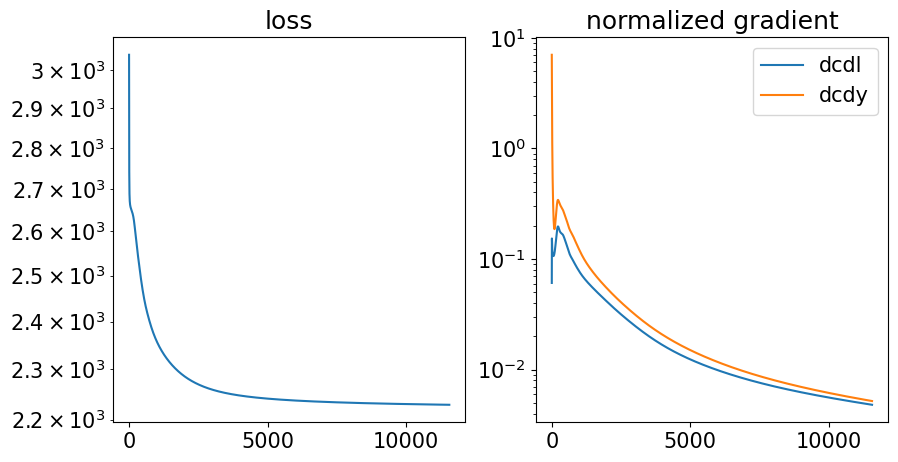

In [69]:
train_obj = ztheta(x_train, 0.005, 50000, 20, True, True)

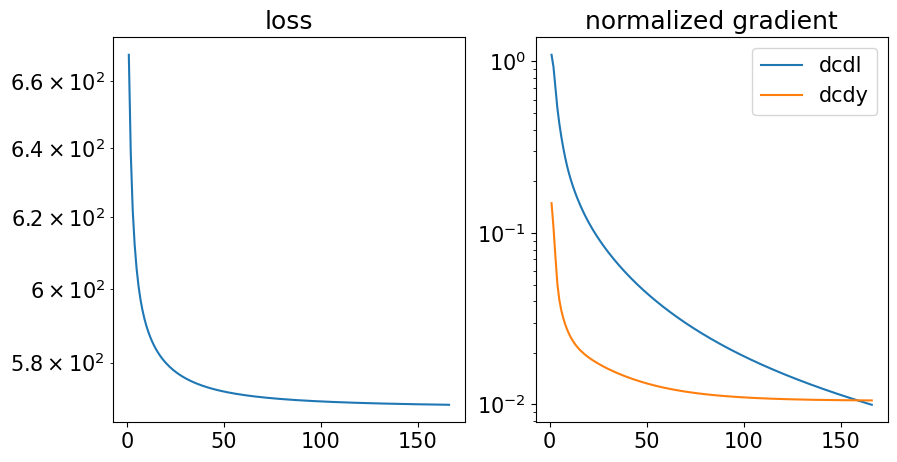

In [70]:
test_obj = ztheta(x_test, 0.1, 2000, 20, True, False, train_obj.theta)

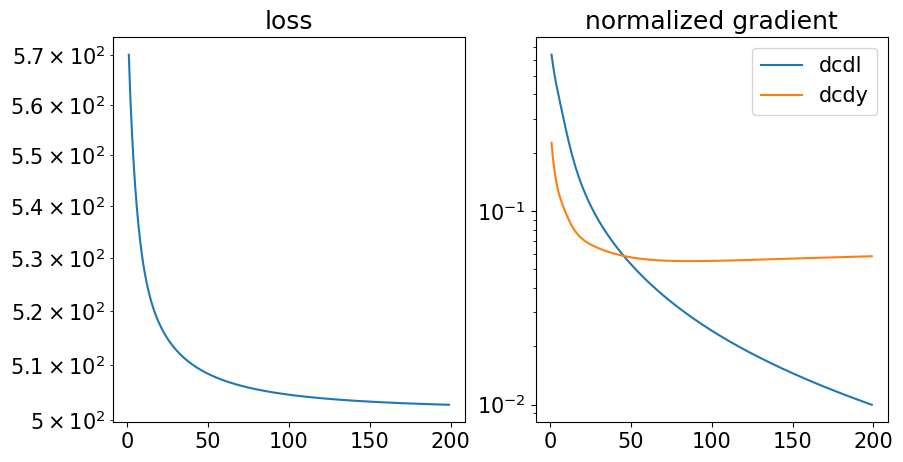

In [27]:
cow_2 = np.array(pd.read_csv('data_files/data_Cows_2.csv',index_col=0))
nordic_obj = ztheta(cow_2, 0.1, 200, 16, True, False, train_obj.theta)

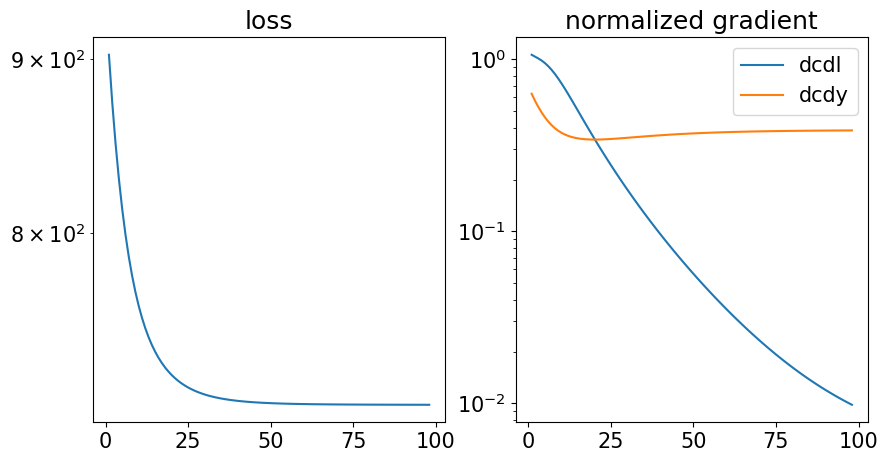

In [35]:
theta_scrambled = np.random.permutation(train_obj.theta.reshape(-1)).reshape(16, -1)
scrambled_obj = ztheta(cow_2, 0.1, num_steps=1000, num_latents=16, plot=True, theta_initial=theta_scrambled, theta_update=False)

In [36]:
train_reconstruction = np.exp(-np.matmul(train_obj.z, train_obj.theta))
row_sum = np.sum(train_reconstruction, axis=1)
train_reconstruction = train_reconstruction/row_sum[:, np.newaxis]

test_reconstruction = np.exp(-np.matmul(test_obj.z, test_obj.theta))
row_sum = np.sum(test_reconstruction, axis=1)
test_reconstruction = test_reconstruction/row_sum[:, np.newaxis]

nordic_reconstruction = np.exp(-np.matmul(nordic_obj.z, nordic_obj.theta))
row_sum = np.sum(nordic_reconstruction, axis=1)
nordic_reconstruction = nordic_reconstruction/row_sum[:, np.newaxis]

scrambled_reconstruction = np.exp(-np.matmul(scrambled_obj.z, scrambled_obj.theta))
row_sum = np.sum(scrambled_reconstruction, axis=1)
scrambled_reconstruction = scrambled_reconstruction/row_sum[:, np.newaxis]


In [29]:
best_score = -np.inf
for i in range(100):
    model = GM(n_components=2).fit(train_obj.z)
    score = np.mean(model.score_samples(train_obj.z))
    if score > best_score:
        best_score = np.copy(score)
        gm = model
print(np.mean(gm.score_samples(train_obj.z)), best_score)

-1.681350136375462 -1.681350136375462


In [37]:
kl_train = sp.stats.entropy(x_train, train_reconstruction, axis=1)
kl_test = sp.stats.entropy(x_test, test_reconstruction, axis=1)
kl_nordic = sp.stats.entropy(cow_2, nordic_reconstruction, axis=1)
kl_scrambled = sp.stats.entropy(cow_2, scrambled_reconstruction, axis=1)

ll_train = gm.score_samples(train_obj.z)/np.log(10)
ll_test = gm.score_samples(test_obj.z)/np.log(10)
ll_nordic = gm.score_samples(nordic_obj.z)/np.log(10)
ll_scrambled = gm.score_samples(scrambled_obj.z)/np.log(10)


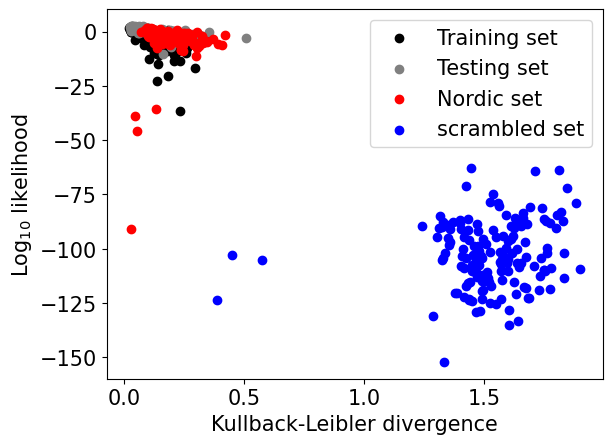

In [41]:
plt.scatter(kl_train, ll_train, color='black', label='Training set')
plt.scatter(kl_test, ll_test, color='grey', label='Testing set')
plt.scatter(kl_nordic, ll_nordic, color='red', label='Nordic set')
plt.scatter(kl_scrambled, ll_scrambled, color='blue', label='scrambled set')
plt.xlabel('Kullback-Leibler divergence')
plt.ylabel(r'$\mathrm{Log}_{10}$ likelihood')
# plt.xticks([0,0.1,0.2,0.3, 0.4])
# plt.ylim([-60, 20])
plt.savefig('figures/SI_3_f.pdf', format='pdf')
plt.legend()
plt.show()

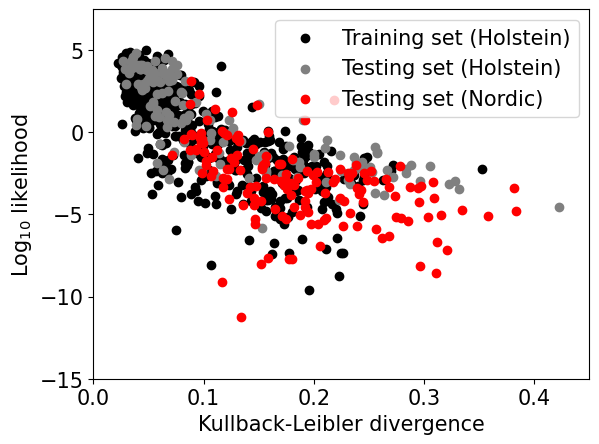

In [44]:
plt.scatter(kl_train, ll_train, color='black', label='Training set (Holstein)')
plt.scatter(kl_test, ll_test, color='grey', label='Testing set (Holstein)')
plt.scatter(kl_nordic, ll_nordic, color='red', label='Testing set (Nordic)')
plt.xlabel('Kullback-Leibler divergence')
plt.ylabel(r'$\mathrm{Log}_{10}$ likelihood')
plt.xticks([0,0.1,0.2,0.3, 0.4])
plt.ylim([-15, 7.5])
plt.xlim([0, 0.45])
plt.legend()
plt.savefig('figures/fig_2_f.pdf', dpi=300, format='pdf')
plt.show()

In [43]:
import seaborn as sns

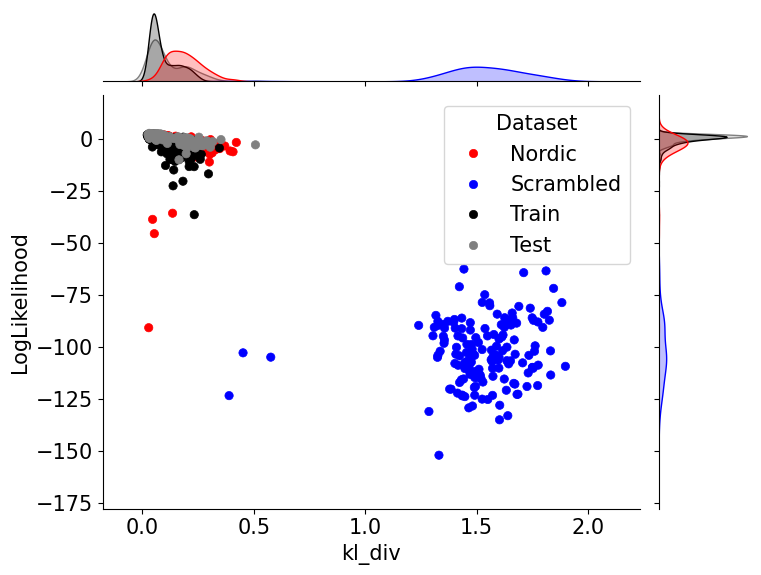

In [44]:
# Create dataframes
nordic_df = pd.DataFrame(np.vstack((kl_nordic, ll_nordic)).T, columns=['kl_div', 'LogLikelihood'])
scrambled_df = pd.DataFrame(np.vstack((kl_scrambled, ll_scrambled)).T, columns=['kl_div', 'LogLikelihood'])
train_df = pd.DataFrame(np.vstack((kl_train, ll_train)).T, columns=['kl_div', 'LogLikelihood'])
test_df = pd.DataFrame(np.vstack((kl_test, ll_test)).T, columns=['kl_div', 'LogLikelihood'])

# Combine all dataframes into one with a new column indicating the dataset
nordic_df['Dataset'] = 'Nordic'
scrambled_df['Dataset'] = 'Scrambled'
train_df['Dataset'] = 'Train'
test_df['Dataset'] = 'Test'

combined_df = pd.concat([nordic_df, scrambled_df, train_df, test_df])

# Define a custom color palette
custom_palette = {"Nordic": "red", "Scrambled": "blue", 'Train': 'Black', 'Test': 'grey'}

# Create the joint plot with custom colors
g = sns.jointplot(data=combined_df, marker='o', x='kl_div', y='LogLikelihood', hue='Dataset', palette=custom_palette,
                  marginal_kws=dict(common_norm=False), joint_kws={'edgecolor':None})



# Set the figure size
g.fig.set_size_inches(8, 6)

# Save the plot as a PDF
g.fig.savefig("figures/SI_3_f.pdf", format="pdf")

# Show the plot
plt.show()